In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class Node:
    # Represents a node in the decision tree
    # feature - which attribute to test
    # branches - dictionary mapping feature values to child nodes
    # value - the prediction (only for leaf nodes)
    def __init__(self, feature=None, branches=None, value=None):
        self.feature = feature  # The feature to split on at this node
        self.branches = branches or {}  # Subtrees for each feature value
        self.value = value  # Prediction stored at leaf nodes

In [19]:
class DecisionTreeID3:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Maximum depth of the tree, limits complexity
        self.root = None  # Root node of the tree

    def entropy(self, labels):
        # Calculate entropy of the target variable `y`
        probs = labels.value_counts(normalize=True)  # Proportion of each class in `y`
        return -sum(probs * np.log2(probs))  # Entropy formula: -Σp*log2(p)

    def information_gain(self, labels, labels_split):
        # Calculate information gain from a split
        parent_entropy = self.entropy(labels)  # Entropy before splitting
        # Weighted sum of entropies of the child nodes
        weighted_entropy = sum((len(subset) / len(labels)) * self.entropy(subset) for subset in labels_split)
        return parent_entropy - weighted_entropy  # Reduction in entropy after the split

    def find_best_feature(self, features, labels):
        # Find the feature that provides the best split
        best_feature = None  # The feature with the highest information gain
        best_gain = -1  # Track the highest information gain
        best_splits = None  # Store the resulting splits for the best feature

        for feature in features.columns:  # Iterate through each feature
            # Create splits by grouping the data by unique feature values
            splits = {value: labels[features[feature] == value] for value in features[feature].unique()}
            labels_split = list(splits.values())  # Convert to list of Series for calculation

            gain = self.information_gain(labels, labels_split)  # Calculate information gain for the feature
            if gain > best_gain:  # Update if the current feature has better information gain
                best_gain = gain
                best_feature = feature
                best_splits = splits

        return best_feature, best_splits  # Return the feature and its splits

    def build_tree(self, features, labels, depth=0):
        # Recursively build the decision tree
        if len(set(labels)) == 1:  # If all target labels are the same, it's a pure node
            return Node(value=labels.iloc[0])  # Create a leaf node with the target value
        if not features.columns.size or (self.max_depth and depth >= self.max_depth):
            # If no features left or max depth reached, return majority class
            return Node(value=labels.value_counts().idxmax())  # Most common target label

        # Find the best feature and splits for this level
        best_feature, best_splits = self.find_best_feature(features, labels)
        if not best_feature:  # If no meaningful split is found, return majority class
            return Node(value=labels.value_counts().idxmax())

        # Create a decision node with branches for each unique value of the best feature
        branches = {}
        for value, subset in best_splits.items():  # For each feature value
            subset_features = features[features[best_feature] == value].drop(columns=[best_feature])  # Remove used feature
            branches[value] = self.build_tree(subset_features, subset, depth + 1)  # Recursively build the tree

        return Node(feature=best_feature, branches=branches)  # Return the decision node

    def fit(self, features, labels):
        # Train the decision tree by building it from the data
        self.root = self.build_tree(features, labels)  # Build the tree starting from the root

    def predict_single(self, node, feature):
        # Predict the label for a single instance by traversing the tree
        if node.value is not None:  # If it's a leaf node, return the stored value
            return node.value
        feature_value = feature[node.feature]  # Get the value of the feature at this node
        if feature_value in node.branches:  # Check if there's a branch for this value
            return self.predict_single(node.branches[feature_value], feature)  # Traverse to the child node
        return None  # If no branch matches, return None (optional: handle this case separately)

    def predict(self, features):
        # Predict the labels for multiple instances
        return [self.predict_single(self.root, feature) for _, feature in features.iterrows()]  # Apply predict_single to each row


In [43]:
def visualise_tree_simple(tree):
    
    def plot_node(node, x, y, dx, level=0):
        # Plot current node
        if node.value is not None:
            label = f"Predict: {node.value}"
        else:
            label = f"Split: {node.feature}"
            
        # Draw node
        plt.plot(x, y, 'o', color='lightblue', markersize=30)
        plt.text(x, y, label, ha='center', va='center', fontsize=8)
        
        # Process children
        if node.branches:
            children = list(node.branches.items())
            width = dx / len(children)
            
            for i, (_, child) in enumerate(children):
                child_x = x - dx/2 + (i + 0.5) * width
                child_y = y - 1
                
                # Draw line to child
                plt.plot([x, child_x], [y, child_y], '-k')
                
                # Recursively plot child
                plot_node(child, child_x, child_y, width, level+1)
    
    plt.figure(figsize=(10, 6))
    plot_node(tree.root, x=0, y=0, dx=8)
    plt.title("Decision Tree")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Predictions: ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
Accuracy: 100.00%


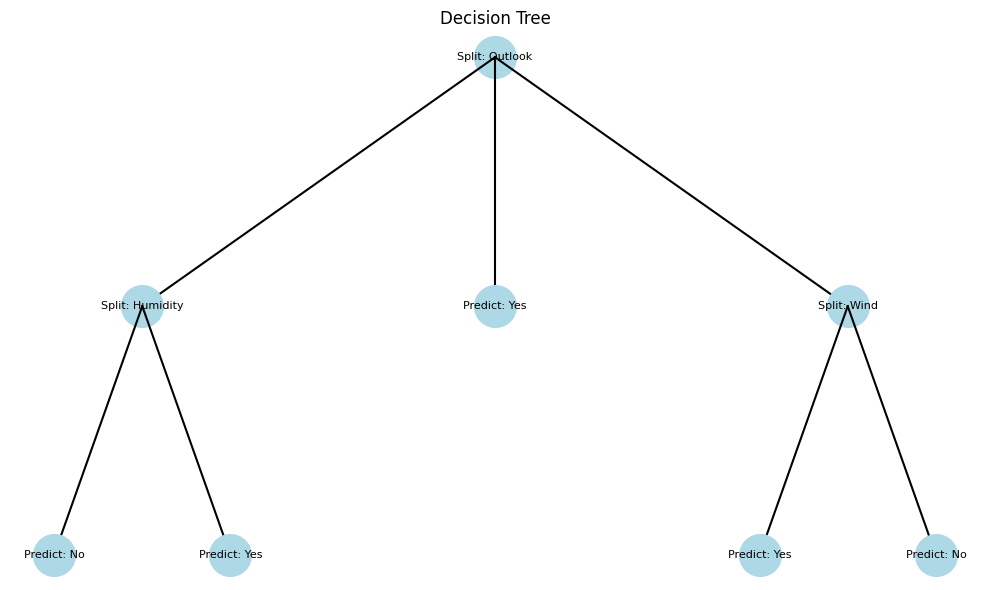

In [48]:
# Train and Test

data = pd.read_csv('weather-data.csv')

features = data.drop(columns=['Decision', 'Day'])  # Remove both Decision and Day
labels = data['Decision']

tree = DecisionTreeID3(max_depth=3)
tree.fit(features, labels)

predictions = tree.predict(features)
print("Predictions:", predictions)

accuracy = sum(pred == actual for pred, actual in zip(predictions, labels)) / len(labels)
print(f"Accuracy: {accuracy:.2%}")

visualise_tree_simple(tree)